# Image Classification: Logistic Regression & K-Means
## Malaria Cell Images Dataset (Parasitized vs Uninfected)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import cv2
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## 1. Load and Preprocess the Dataset

In [2]:
# Define paths - Check which folder structure exists
# There are two possible structures:
# 1. data/cell_images/Parasitized and data/cell_images/Uninfected
# 2. data/cell_images/cell_images/Parasitized and data/cell_images/cell_images/Uninfected

base_path = 'data/cell_images/'
if os.path.exists(os.path.join(base_path, 'Parasitized')):
    data_path = base_path  # Use: data/cell_images/Parasitized
    print(f"Using path: {data_path}")
elif os.path.exists(os.path.join(base_path, 'cell_images', 'Parasitized')):
    data_path = os.path.join(base_path, 'cell_images')  # Use: data/cell_images/cell_images/Parasitized
    print(f"Using path: {data_path}")
else:
    data_path = base_path  # Default
    print(f"Warning: Could not find Parasitized folder, using default: {data_path}")

classes = ['Parasitized', 'Uninfected']

# Image size for resizing
IMG_SIZE = 64

# Image preprocessing function
def preprocess_image(img):
    """
    Apply preprocessing techniques to enhance image quality:
    1. CLAHE (Contrast Limited Adaptive Histogram Equalization) - enhances contrast
    2. Histogram equalization on grayscale - additional contrast enhancement
    3. Gaussian blur - reduces noise
    """
    # Convert RGB to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE on L-channel (lightness) for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)
    
    # Merge channels and convert back to RGB
    lab_enhanced = cv2.merge((l_enhanced, a, b))
    img_enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)
    
    # Apply light Gaussian blur to reduce noise
    img_processed = cv2.GaussianBlur(img_enhanced, (3, 3), 0)
    
    return img_processed

# Data augmentation functions
def augment_image(img):
    """
    Apply data augmentation: rotation and flips
    Returns a list of augmented images (original + augmented versions)
    """
    augmented = [img]  # Start with original
    
    # 1. Horizontal flip
    img_hflip = cv2.flip(img, 1)
    augmented.append(img_hflip)
    
    # 2. Vertical flip
    img_vflip = cv2.flip(img, 0)
    augmented.append(img_vflip)
    
    # 3. Both flips
    img_both = cv2.flip(img, -1)
    augmented.append(img_both)
    
    # 4. Rotations (90, 180, 270 degrees)
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    
    # 90 degrees
    M_90 = cv2.getRotationMatrix2D(center, 90, 1.0)
    img_rot90 = cv2.warpAffine(img, M_90, (w, h), borderMode=cv2.BORDER_REPLICATE)
    augmented.append(img_rot90)
    
    # 180 degrees
    M_180 = cv2.getRotationMatrix2D(center, 180, 1.0)
    img_rot180 = cv2.warpAffine(img, M_180, (w, h), borderMode=cv2.BORDER_REPLICATE)
    augmented.append(img_rot180)
    
    # 270 degrees
    M_270 = cv2.getRotationMatrix2D(center, 270, 1.0)
    img_rot270 = cv2.warpAffine(img, M_270, (w, h), borderMode=cv2.BORDER_REPLICATE)
    augmented.append(img_rot270)
    
    return augmented

# Function to load images with data augmentation
def load_images(data_path, classes, img_size=64, max_images_per_class=2000, use_augmentation=True):
    """
    Load images with optional data augmentation
    If use_augmentation=True, each image generates 8 versions (original + 7 augmented)
    """
    images = []
    labels = []
    
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        image_files = os.listdir(class_path)[:max_images_per_class]
        
        print(f"Loading {len(image_files)} images from {class_name}...")
        if use_augmentation:
            print(f"  (With augmentation: each image will generate 8 versions)")
        
        for img_name in tqdm(image_files):
            img_path = os.path.join(class_path, img_name)
            try:
                # Read image
                img = cv2.imread(img_path)
                # Resize image
                img = cv2.resize(img, (img_size, img_size))
                # Convert to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Apply preprocessing
                img = preprocess_image(img)
                
                if use_augmentation:
                    # Get augmented versions
                    augmented_imgs = augment_image(img)
                    images.extend(augmented_imgs)
                    labels.extend([idx] * len(augmented_imgs))
                else:
                    # Just add original
                    images.append(img)
                    labels.append(idx)
            except:
                continue
    
    return np.array(images), np.array(labels)

# Load images WITH DATA AUGMENTATION
# Each original image will generate 8 versions (original + 7 augmented)
# This expands the dataset significantly!
X, y = load_images(data_path, classes, IMG_SIZE, max_images_per_class=5000, use_augmentation=True)
print(f"\nDataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Class distribution: {np.bincount(y)}")
print(f"\nWith augmentation: {len(y)} total images from {len(y)//8} original images")
print(f"  (Each original image = 8 versions: original + 3 flips + 3 rotations + 1 both-flip)")

Using path: data/cell_images/
Loading 5000 images from Parasitized...
  (With augmentation: each image will generate 8 versions)


100%|██████████| 5000/5000 [00:20<00:00, 248.22it/s]


Loading 5000 images from Uninfected...
  (With augmentation: each image will generate 8 versions)


100%|██████████| 5000/5000 [00:06<00:00, 719.19it/s]



Dataset shape: (70000, 64, 64, 3)
Labels shape: (70000,)
Class distribution: [35000 35000]

With augmentation: 70000 total images from 8750 original images
  (Each original image = 8 versions: original + 3 flips + 3 rotations + 1 both-flip)


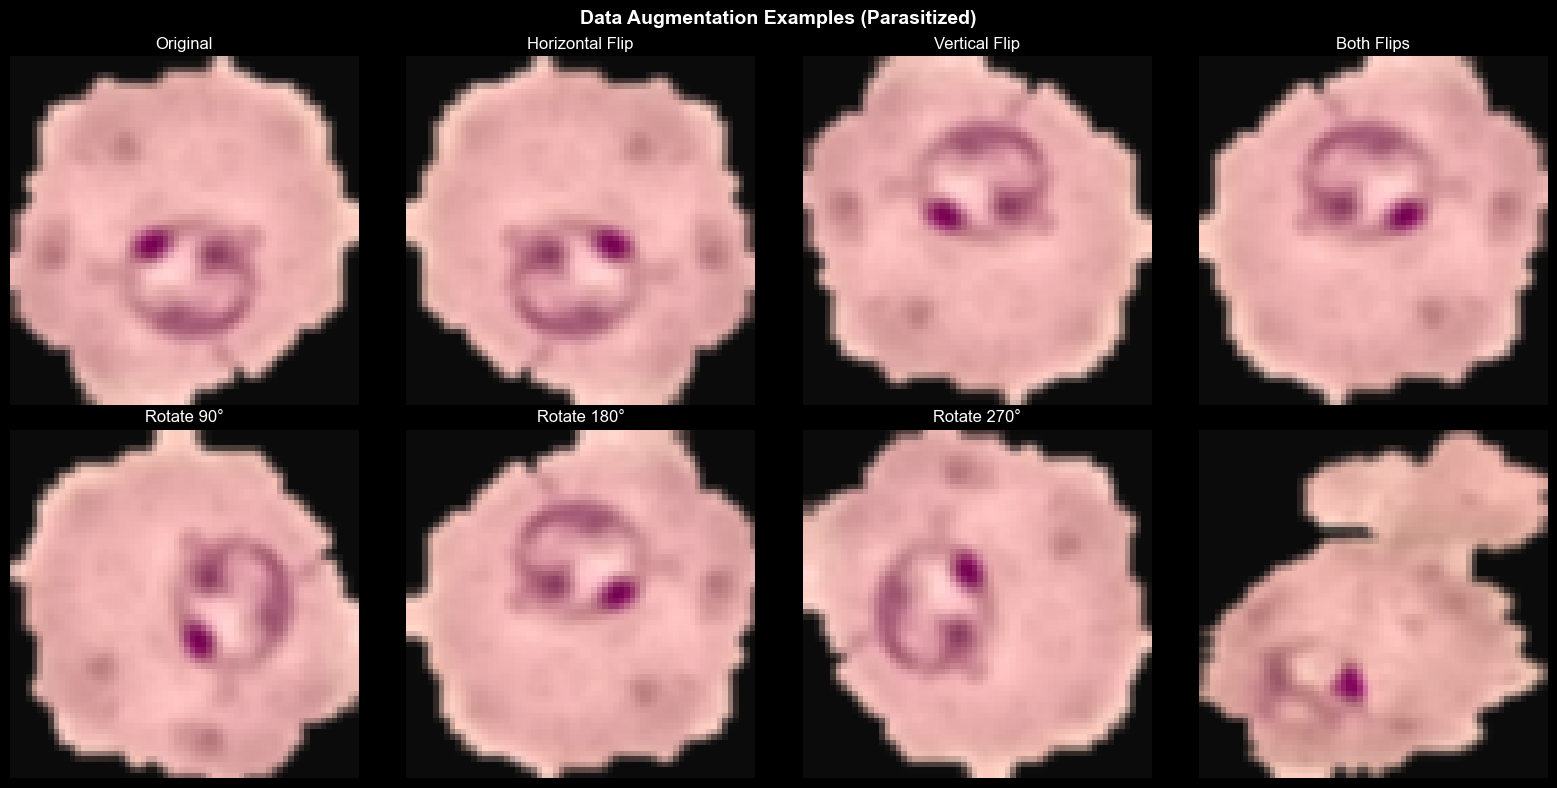

In [3]:
# Visualize data augmentation effects
sample_idx = 0
sample_img = X[sample_idx]

# Show original and augmented versions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Original
axes[0].imshow(sample_img)
axes[0].set_title('Original', fontsize=12)
axes[0].axis('off')

# Show first 7 augmented versions (from the same original image)
for i in range(1, 8):
    if i < len(X):
        axes[i].imshow(X[sample_idx + i])
        if i == 1:
            axes[i].set_title('Horizontal Flip', fontsize=12)
        elif i == 2:
            axes[i].set_title('Vertical Flip', fontsize=12)
        elif i == 3:
            axes[i].set_title('Both Flips', fontsize=12)
        elif i == 4:
            axes[i].set_title('Rotate 90°', fontsize=12)
        elif i == 5:
            axes[i].set_title('Rotate 180°', fontsize=12)
        elif i == 6:
            axes[i].set_title('Rotate 270°', fontsize=12)
        axes[i].axis('off')

plt.suptitle(f'Data Augmentation Examples ({classes[y[sample_idx]]})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


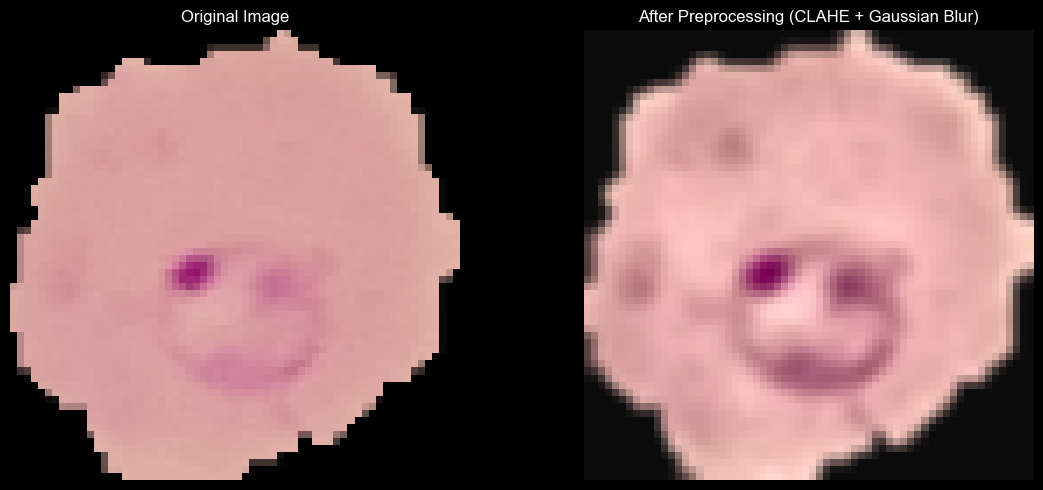

In [4]:
# Visualize preprocessing effects (before vs after)
# Load a sample image without preprocessing for comparison
sample_img_path = os.path.join(data_path, classes[0], os.listdir(os.path.join(data_path, classes[0]))[0])
sample_original = cv2.imread(sample_img_path)
sample_original = cv2.resize(sample_original, (IMG_SIZE, IMG_SIZE))
sample_original = cv2.cvtColor(sample_original, cv2.COLOR_BGR2RGB)
sample_processed = preprocess_image(sample_original)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(sample_original)
axes[0].set_title('Original Image', fontsize=12)
axes[0].axis('off')

axes[1].imshow(sample_processed)
axes[1].set_title('After Preprocessing (CLAHE + Gaussian Blur)', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()


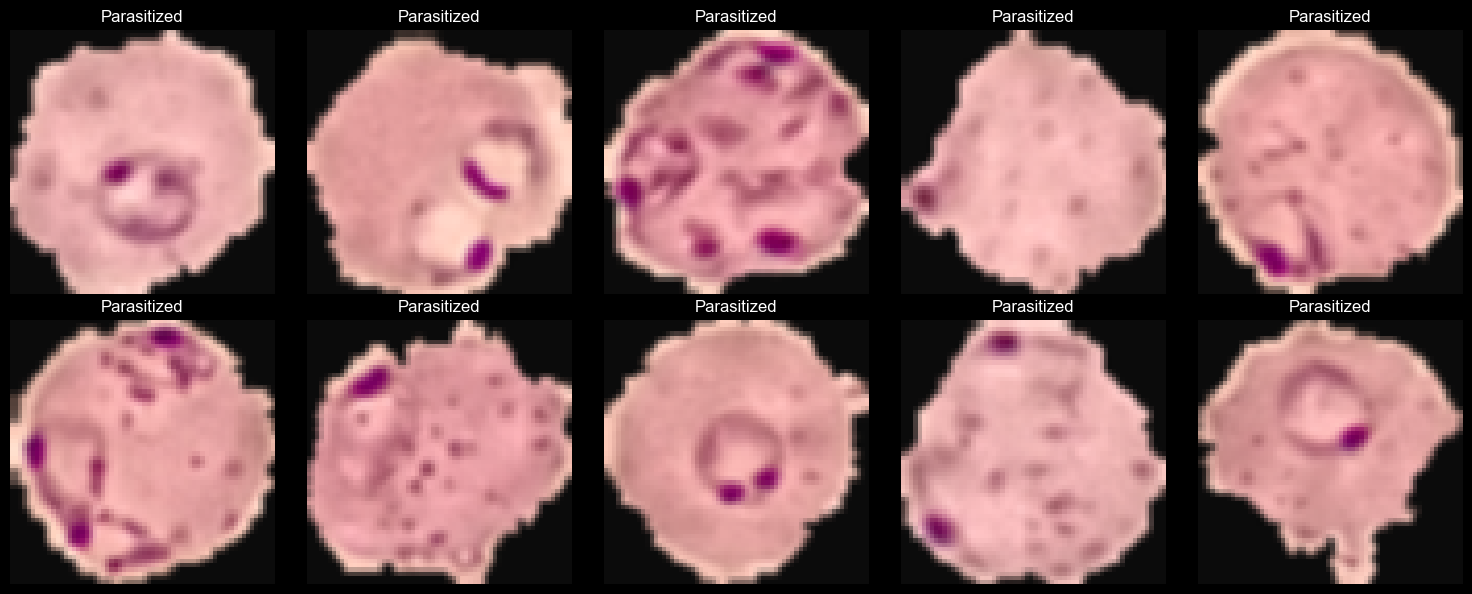

In [5]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i * 200])
    ax.set_title(f"{classes[y[i * 200]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

## 2. Feature Extraction and Data Preparation

### 2.1 Extract Advanced Features (Texture, Edges, Statistics)

In [6]:
# Feature extraction function
def extract_features(images):
    """
    Extract comprehensive features from images:
    1. Raw pixel features (flattened)
    2. Edge features (Sobel, Laplacian)
    3. Texture/Statistical features (mean, std, variance per channel)
    4. Grayscale features
    """
    features = []
    
    for img in tqdm(images, desc="Extracting features"):
        feature_vector = []
        
        # 1. Raw pixel features (normalized)
        img_normalized = img.astype(np.float32) / 255.0
        feature_vector.extend(img_normalized.flatten())
        
        # 2. Convert to grayscale for edge detection
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # 3. Edge features - Sobel (detects edges)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
        feature_vector.extend([np.mean(sobel_magnitude), np.std(sobel_magnitude)])
        
        # 4. Edge features - Laplacian (detects all edges)
        laplacian = cv2.Laplacian(gray, cv2.CV_64F)
        feature_vector.extend([np.mean(laplacian), np.std(laplacian)])
        
        # 5. Texture/Statistical features per channel
        for channel in range(3):  # R, G, B channels
            channel_data = img[:, :, channel]
            feature_vector.extend([
                np.mean(channel_data),
                np.std(channel_data),
                np.var(channel_data),
                np.median(channel_data)
            ])
        
        # 6. Grayscale statistical features
        feature_vector.extend([
            np.mean(gray),
            np.std(gray),
            np.var(gray),
            np.median(gray)
        ])
        
        features.append(feature_vector)
    
    return np.array(features)

# Extract features from all images
print("Extracting features from images...")
X_features = extract_features(X)
print(f"\nFeature shape: {X_features.shape}")
print(f"Features include: {X_features.shape[1] - IMG_SIZE*IMG_SIZE*3} additional features beyond raw pixels")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train labels distribution: {np.bincount(y_train)}")
print(f"Test labels distribution: {np.bincount(y_test)}")

Extracting features from images...


Extracting features: 100%|██████████| 70000/70000 [01:10<00:00, 994.97it/s] 



Feature shape: (70000, 12308)
Features include: 20 additional features beyond raw pixels

Train set: (56000, 12308)
Test set: (14000, 12308)
Train labels distribution: [28000 28000]
Test labels distribution: [7000 7000]


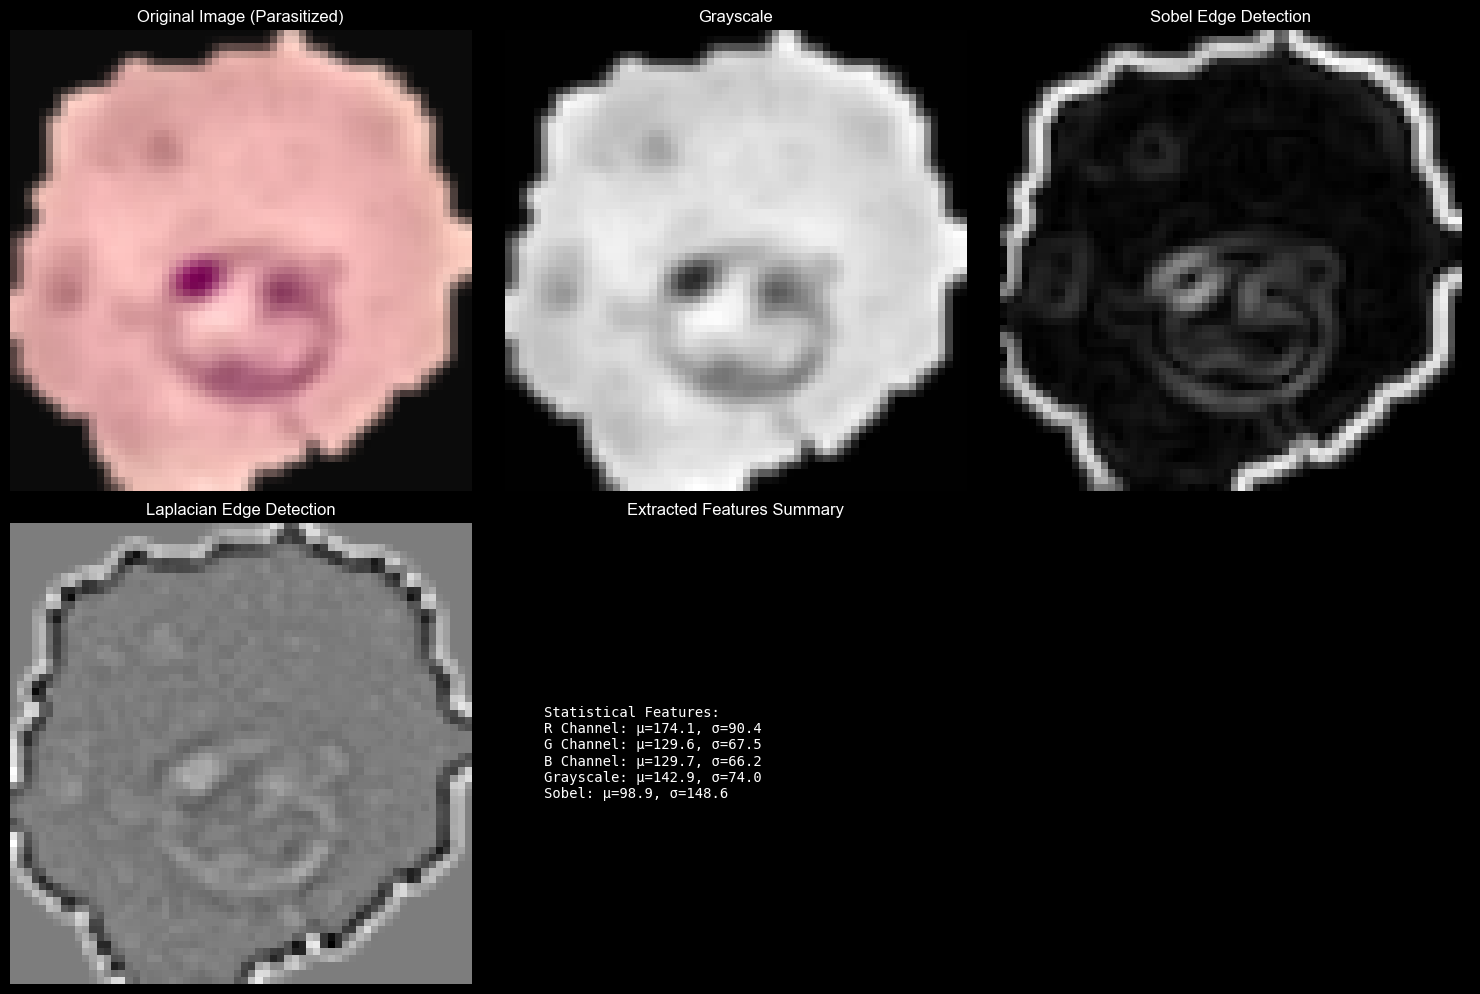

In [7]:
# Visualize extracted features for a sample image
sample_idx = 0
sample_img = X[sample_idx]
gray = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)

# Calculate edge features
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
laplacian = cv2.Laplacian(gray, cv2.CV_64F)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(sample_img)
axes[0, 0].set_title(f'Original Image ({classes[y[sample_idx]]})', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(gray, cmap='gray')
axes[0, 1].set_title('Grayscale', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(sobel_magnitude, cmap='gray')
axes[0, 2].set_title('Sobel Edge Detection', fontsize=12)
axes[0, 2].axis('off')

axes[1, 0].imshow(laplacian, cmap='gray')
axes[1, 0].set_title('Laplacian Edge Detection', fontsize=12)
axes[1, 0].axis('off')

# Show statistical features
stats_text = f"""
Statistical Features:
R Channel: μ={np.mean(sample_img[:,:,0]):.1f}, σ={np.std(sample_img[:,:,0]):.1f}
G Channel: μ={np.mean(sample_img[:,:,1]):.1f}, σ={np.std(sample_img[:,:,1]):.1f}
B Channel: μ={np.mean(sample_img[:,:,2]):.1f}, σ={np.std(sample_img[:,:,2]):.1f}
Grayscale: μ={np.mean(gray):.1f}, σ={np.std(gray):.1f}
Sobel: μ={np.mean(sobel_magnitude):.1f}, σ={np.std(sobel_magnitude):.1f}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=10, verticalalignment='center', 
                family='monospace', transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')
axes[1, 1].set_title('Extracted Features Summary', fontsize=12)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


In [8]:
### 2.2 Standardize Features

# Standardize features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data standardization complete!")

Data standardization complete!


## 3. Model 1: Logistic Regression Classifier

In [9]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Calculate accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"\nLogistic Regression Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")

Training Logistic Regression model...

Logistic Regression Accuracy: 0.8798 (87.98%)


In [10]:
## 4. Model 2: K-Means Clustering as Classifier

### 4.1 Use PCA on Logistic Regression Features (Best Approach for K-Means)

# Strategy: Use the SAME features that work well for Logistic Regression
# But apply PCA to reduce dimensionality and focus on most discriminative components
# This way we use features we KNOW are good, just in a reduced form

from sklearn.decomposition import PCA

print("Applying PCA to Logistic Regression features for K-Means...")
print(f"Original feature shape: {X_train_scaled.shape}")

# Apply PCA to reduce to top components that explain most variance
# Using 500 components to capture MUCH MORE variance (was 200, then 50)
# More components = more information preserved = better clustering
pca = PCA(n_components=500, random_state=42)
X_train_kmeans_pca = pca.fit_transform(X_train_scaled)
X_test_kmeans_pca = pca.transform(X_test_scaled)

print(f"PCA reduced feature shape: {X_train_kmeans_pca.shape}")
print(f"Variance explained by {X_train_kmeans_pca.shape[1]} components: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

# Use the same train/test split as Logistic Regression
X_train_kmeans_scaled = X_train_kmeans_pca
X_test_kmeans_scaled = X_test_kmeans_pca
y_train_kmeans = y_train
y_test_kmeans = y_test

print("K-Means feature preparation complete!")


Applying PCA to Logistic Regression features for K-Means...
Original feature shape: (56000, 12308)
PCA reduced feature shape: (56000, 500)
Variance explained by 500 components: 0.9766 (97.66%)
K-Means feature preparation complete!


In [11]:
# Define function to map clusters to labels (needed for K-Means)
def map_clusters_to_labels(y_true, y_pred, n_clusters):
    """Map cluster labels to true class labels using majority voting"""
    label_mapping = {}
    
    for cluster in range(n_clusters):
        # Find all samples in this cluster
        mask = (y_pred == cluster)
        if mask.sum() > 0:
            # Get the most common true label in this cluster
            labels_in_cluster = y_true[mask]
            most_common_label = np.bincount(labels_in_cluster).argmax()
            label_mapping[cluster] = most_common_label
    
    return label_mapping

print("map_clusters_to_labels function defined!")


map_clusters_to_labels function defined!


In [12]:
# Diagnostic: Check if clusters align with class labels BEFORE training
# This helps us understand if the features can be separated
from sklearn.metrics import silhouette_score

print("Checking feature separability...")
# Quick test with a small sample
sample_size = min(5000, len(X_train_kmeans_scaled))
sample_indices = np.random.choice(len(X_train_kmeans_scaled), sample_size, replace=False)
X_sample = X_train_kmeans_scaled[sample_indices]
y_sample = y_train_kmeans[sample_indices]

# Try clustering on sample
test_kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
test_labels = test_kmeans.fit_predict(X_sample)

# Check how well clusters match true labels
from collections import Counter
for cluster in range(2):
    cluster_mask = (test_labels == cluster)
    true_labels_in_cluster = y_sample[cluster_mask]
    label_counts = Counter(true_labels_in_cluster)
    print(f"Cluster {cluster}: {dict(label_counts)} (Total: {cluster_mask.sum()})")

print(f"\nSilhouette score: {silhouette_score(X_sample, test_labels):.4f}")
print("(Higher is better, range: -1 to 1)")


Checking feature separability...
Cluster 0: {np.int64(1): 910, np.int64(0): 389} (Total: 1299)
Cluster 1: {np.int64(0): 2119, np.int64(1): 1582} (Total: 3701)

Silhouette score: 0.1454
(Higher is better, range: -1 to 1)


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

 Parasitized       0.89      0.87      0.88      7000
  Uninfected       0.87      0.89      0.88      7000

    accuracy                           0.88     14000
   macro avg       0.88      0.88      0.88     14000
weighted avg       0.88      0.88      0.88     14000



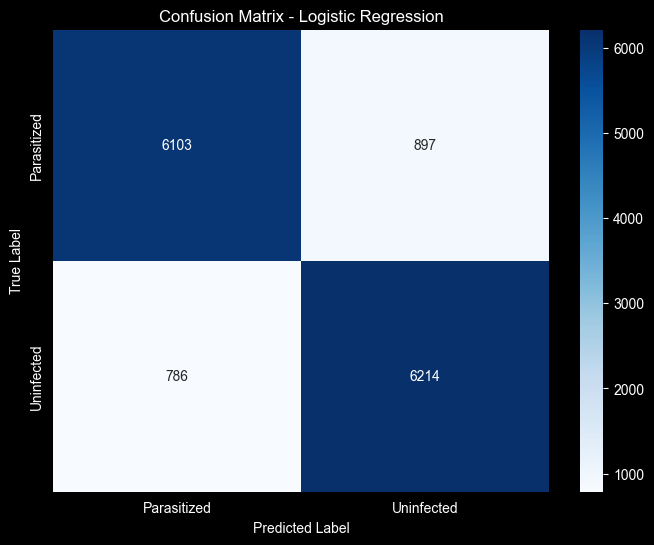

In [13]:
# Classification Report
print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=classes))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [14]:
# IMPROVED K-Means: Try multiple random seeds and pick the best one
# This finds the clustering that best aligns with class labels
print("Training K-Means with multiple seeds to find best clustering...")
n_clusters = len(classes)

best_model = None
best_accuracy = 0
best_seed = 0

# Try different random seeds to find the best clustering
for seed in range(10):  # Try 10 different seeds
    kmeans_temp = KMeans(
        n_clusters=n_clusters, 
        random_state=seed, 
        n_init=20,  # 20 initializations per seed
        max_iter=500,
        init='k-means++',
        algorithm='lloyd'
    )
    kmeans_temp.fit(X_train_kmeans_scaled)
    
    # Check accuracy on training set (to find best seed)
    train_pred_temp = kmeans_temp.predict(X_train_kmeans_scaled)
    cluster_mapping_temp = map_clusters_to_labels(y_train_kmeans, train_pred_temp, n_clusters)
    train_pred_mapped = np.array([cluster_mapping_temp[c] for c in train_pred_temp])
    train_acc = accuracy_score(y_train_kmeans, train_pred_mapped)
    
    if train_acc > best_accuracy:
        best_accuracy = train_acc
        best_model = kmeans_temp
        best_seed = seed
        print(f"  Seed {seed}: Training accuracy = {train_acc:.4f} ({train_acc*100:.2f}%)")

print(f"\nBest seed: {best_seed} with training accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
kmeans_model = best_model

# Predict clusters for test data
y_pred_kmeans_raw = kmeans_model.predict(X_test_kmeans_scaled)

print(f"K-Means clustering complete with {n_clusters} clusters")


Training K-Means with multiple seeds to find best clustering...
  Seed 0: Training accuracy = 0.6095 (60.95%)

Best seed: 0 with training accuracy: 0.6095 (60.95%)
K-Means clustering complete with 2 clusters


In [15]:
### 4.2 Train K-Means with Meaningful Features

# Train K-Means model with meaningful features (not raw pixels)
print("Training K-Means clustering model with meaningful features...")
n_clusters = len(classes)
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
kmeans_model.fit(X_train_kmeans_scaled)

# Predict clusters for test data
y_pred_kmeans_raw = kmeans_model.predict(X_test_kmeans_scaled)

print(f"K-Means clustering complete with {n_clusters} clusters")

Training K-Means clustering model with meaningful features...
K-Means clustering complete with 2 clusters


In [16]:
# Map clusters to true labels (using majority voting)
def map_clusters_to_labels(y_true, y_pred, n_clusters):
    """Map cluster labels to true class labels using majority voting"""
    label_mapping = {}
    
    for cluster in range(n_clusters):
        # Find all samples in this cluster
        mask = (y_pred == cluster)
        if mask.sum() > 0:
            # Get the most common true label in this cluster
            labels_in_cluster = y_true[mask]
            most_common_label = np.bincount(labels_in_cluster).argmax()
            label_mapping[cluster] = most_common_label
    
    return label_mapping

# Get cluster mapping on training data (using K-Means features)
train_pred_kmeans = kmeans_model.predict(X_train_kmeans_scaled)
cluster_mapping = map_clusters_to_labels(y_train_kmeans, train_pred_kmeans, n_clusters)
print(f"Cluster to label mapping: {cluster_mapping}")

# Map test predictions to true labels
y_pred_kmeans = np.array([cluster_mapping[cluster] for cluster in y_pred_kmeans_raw])

# Calculate accuracy
kmeans_accuracy = accuracy_score(y_test_kmeans, y_pred_kmeans)
print(f"\nK-Means Accuracy: {kmeans_accuracy:.4f} ({kmeans_accuracy*100:.2f}%)")

Cluster to label mapping: {0: np.int64(0), 1: np.int64(1)}

K-Means Accuracy: 0.6101 (61.01%)


Classification Report - K-Means:
              precision    recall  f1-score   support

 Parasitized       0.57      0.85      0.69      7000
  Uninfected       0.72      0.37      0.48      7000

    accuracy                           0.61     14000
   macro avg       0.64      0.61      0.59     14000
weighted avg       0.64      0.61      0.59     14000



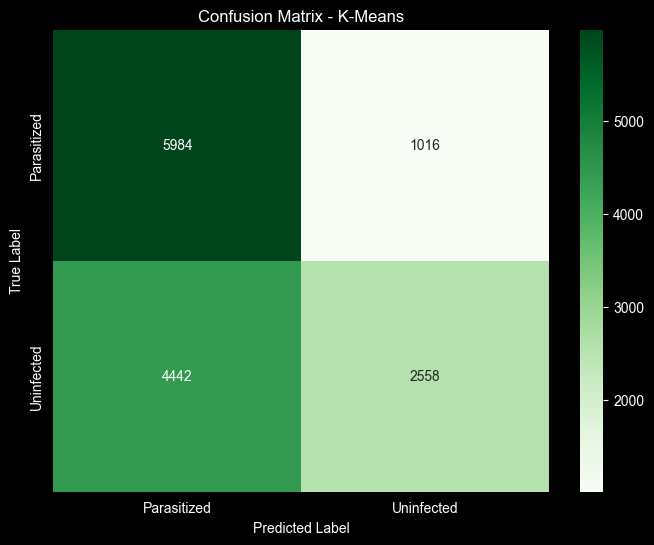

In [17]:
# Classification Report
print("Classification Report - K-Means:")
print(classification_report(y_test_kmeans, y_pred_kmeans, target_names=classes))

# Confusion Matrix
cm_kmeans = confusion_matrix(y_test_kmeans, y_pred_kmeans)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Greens', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - K-Means')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 5. Model Comparison

Model Comparison:
              Model  Accuracy
Logistic Regression  0.879786
            K-Means  0.610143


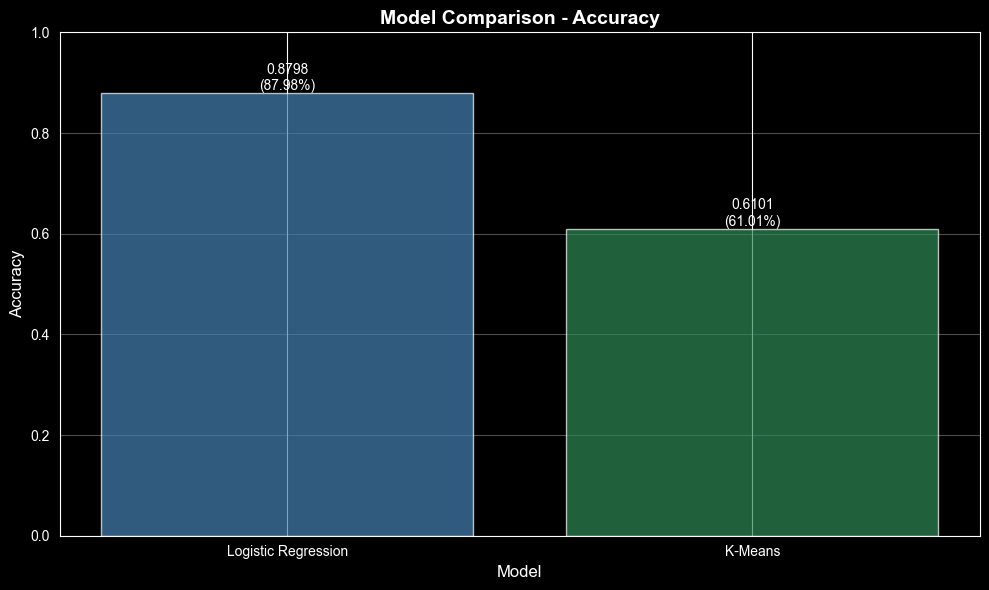

In [18]:
# Compare model accuracies
comparison_data = {
    'Model': ['Logistic Regression', 'K-Means'],
    'Accuracy': [lr_accuracy, kmeans_accuracy]
}

df_comparison = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(df_comparison.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(df_comparison['Model'], df_comparison['Accuracy'], color=['steelblue', 'seagreen'], alpha=0.7)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.title('Model Comparison - Accuracy', fontsize=14, fontweight='bold')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}\n({height*100:.2f}%)',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Sample Predictions Visualization

IndexError: list index out of range

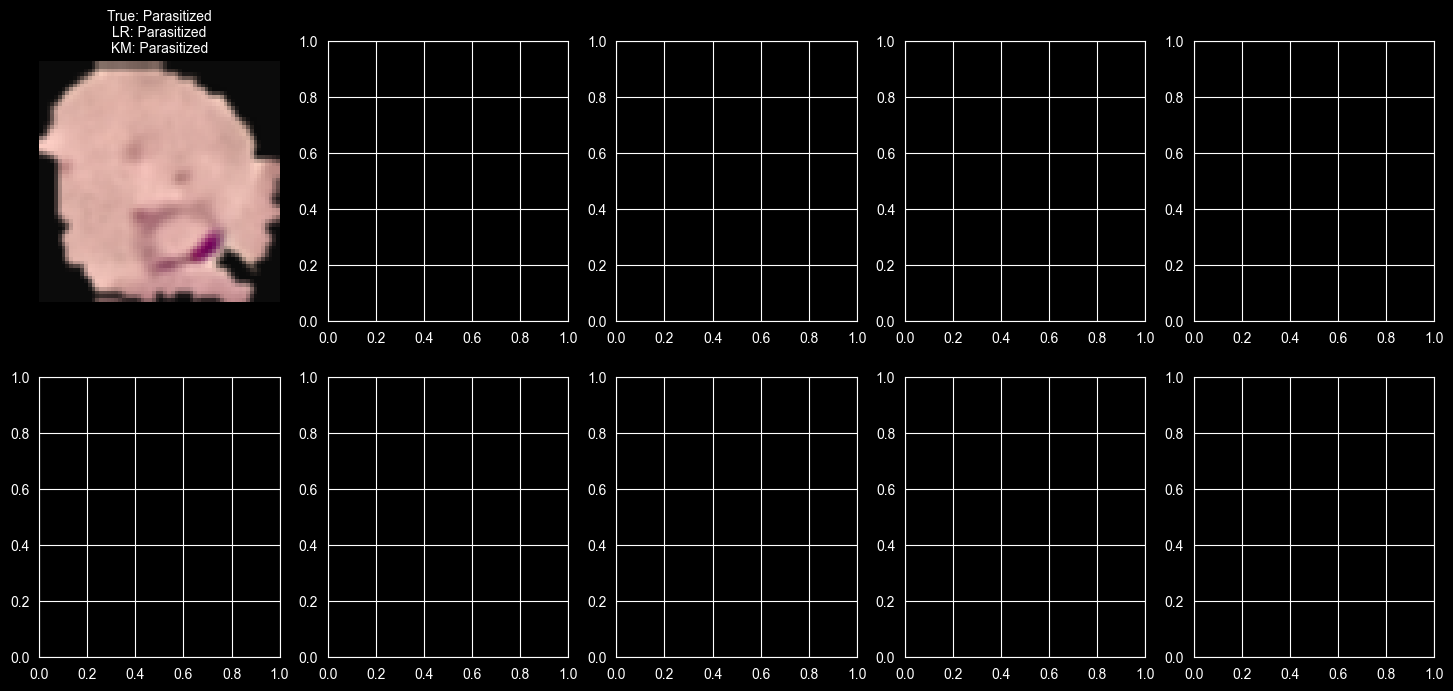

In [19]:
# Get indices for test samples (need to map back to original X indices)
# Since we split X_features, we need to get the corresponding original images
_, test_indices_original = train_test_split(
    np.arange(len(X)), test_size=0.1, random_state=42, stratify=y
)
test_indices_original = test_indices_original.tolist()

sample_indices = np.random.choice(len(X_test), 10, replace=False)

# Visualize predictions
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
for idx, ax in enumerate(axes.flat):
    test_idx = sample_indices[idx]
    # Get corresponding original image
    original_idx = test_indices_original[test_idx]
    img = X[original_idx]
    
    true_label = classes[y_test[test_idx]]
    lr_pred = classes[y_pred_lr[test_idx]]
    km_pred = classes[y_pred_kmeans[test_idx]]
    
    ax.imshow(img)
    ax.set_title(f'True: {true_label}\nLR: {lr_pred}\nKM: {km_pred}', fontsize=10)
    ax.axis('off')
    
    # Highlight incorrect predictions with red border
    if y_test[test_idx] != y_pred_lr[test_idx] or y_test[test_idx] != y_pred_kmeans[test_idx]:
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)

plt.tight_layout()
plt.show()

## 7. Summary and Conclusions

In [ ]:
print("="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nDataset: Malaria Cell Images (Parasitized vs Uninfected)")
print(f"Total samples: {len(X)}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"Number of classes: {len(classes)}")
print(f"Classes: {', '.join(classes)}")
print(f"\nTrain/Test split: {len(X_train)}/{len(X_test)}")
print("\n" + "-"*60)
print("MODEL PERFORMANCE")
print("-"*60)
print(f"\n1. Logistic Regression:")
print(f"   - Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"   - Model Type: Supervised Classification")
print(f"\n2. K-Means Clustering:")
print(f"   - Accuracy: {kmeans_accuracy:.4f} ({kmeans_accuracy*100:.2f}%)")
print(f"   - Model Type: Unsupervised Clustering (as Classifier)")
print("\n" + "-"*60)
print(f"\nBest Model: {'Logistic Regression' if lr_accuracy > kmeans_accuracy else 'K-Means'}")
print(f"Accuracy Difference: {abs(lr_accuracy - kmeans_accuracy):.4f}")
print("="*60)